# 概要
### これは何か
- 日経225の過去日足データから、将来の値動きを予測し、儲けるのAI

### なぜ作ったのか
- 儲けたいという安易なモチベーションに駆られたため

### どのように作ったのか
- 日々の始値で売り・中立・買い（空売り）を行い、終値でポジションを精算することを想定して、ポジションを判定する一次モデルと、ポジションのサイズ（いくら賭けるのか）を判定する二次モデルを組み合わせてトレードを行う
  - 一次モデル：売り・中立・買い（空売り）のポジションを判定するモデル
    - 目的変数：着目している銘柄の翌日の騰落率（=(終値-始値)/終値）が一定閾値以上 or 以下か
    - 説明変数：日経225の当日から5日前までの騰落率
    - モデル：ランダムフォレスト
  - 二次モデル：どの程度ポジションに投資するのかを判定するモデル
    - 目的変数：一次モデルの判定の正否
    - 説明変数：一次モデルの説明変数 + 一次モデルの予測ラベル（メタラベル）
- 評価期間のシャープレシオが上位の銘柄を選定し、テスト期間のパフォーマンスを計測（閾値はハンドチューニング）
  - 学習：2014年以前のデータ
  - 評価：2015-2017年のデータ
  - テスト：2018-2020年のデータ

### 儲かりそうか
- 儲かる可能性はありそうだけど、身銭を切って使うのはまだ怖いレベル
  - テスト期間の3年間で30%程度のリターン（信用取引の利息（年間4%くらい）を考慮せずにバックテストしたところ50%くらいのリターンだったので）
  - リターンの大半は直近のコロナバブルによるものなので、今後も使えるものなのか、非常に怪しい。。


In [ ]:
# ライブラリインポート
import pandas_datareader.data as web
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import cdist
import datetime
import os

# 定数
filepath = './nikkei225.csv' # ロードした株価データの格納先
spread = 0.4/365. #1日4%の金利

In [ ]:
def load_stock_data(target_codes, filepath):
  '''株価データを取得してcsvに格納する
  target_codes: 分析対象の株の証券コードを並べたリスト
  filepath: 取得した株価データの格納先
  df: Symbol（証券コード）、Date（日付）を主キーとした、Open（始値）, Low（安値）, High（高値）, Close（終値）, Volume（出来高）のデータ
  '''

  # 株価データの取得
  df = pandas_datareader.stooq.StooqDailyReader(
      symbols=[str(c) + '.JP' for c in target_codes], start='JAN-01-2010', end="JAN-28-2021"
      ).read().sort_values(by='Date',ascending=True)

  # 分析用に整形
  df = pd.DataFrame({'price':df.unstack()}).reset_index()
  df = df.pivot_table(index=['Symbols', 'Date'], columns=['Attributes'], values='price').reset_index()
  df.to_csv(filepath)

def to_datamart(df):
  '''目的変数と説明変数を付与する
  目的変数：1日後の始値と終値の騰落率（=(終値-始値)/始値）
  説明変数：当日から5日前までのそれぞれの日における始値と終値の騰落率（=(終値-始値)/始値）
  '''
  symbol = df.Symbols.iloc[0]

  #目的変数
  for n in range(1, 2, 1):
    df['Profit_'+str(n)+'D_after_' + str(symbol)] = (df['Close'].shift(-n-1) - df['Open'].shift(-1) )/df['Open'].shift(-1)

  #説明変数
  for n in range(0, 5, 1):
    df['Lag_'+str(n)+'D_before_' + str(symbol)] = ( df['Close'] - df['Open'].shift(n) ) / df['Open'].shift(n)

  return df

def fillna_df(df):
  '''欠損値を前日の値で補間する
  '''
  s_old = df.isna().sum().sum()
  df = df.fillna(method='ffill')
  s_new = df.isna().sum().sum()

  # 原則前日の値を使って欠損値補間
  i = 0
  while s_old - s_new>0: 
    s_old = s_new
    df = df.fillna(method='ffill')
    s_new = df.isna().sum().sum()
    if i > 100:
      break
    else:
      i += 1

  # 前日の値で埋めきれなかったものは翌日の値で補間
  while s_new > 0:
    df = df.fillna(method='bfill')
    s_new = df.isna().sum().sum()
    if i > 100:
      break
    else:
      i += 1

  return df

def make_model(df_master, target_symbol, symbols_modified, plot=True, metalabel=True):
  '''翌日の騰落率を予測するModelを生成し、学習、期間内の収益シミュレーションまで実行する
  '''
  # from sklearn import linear_model
  # from sklearn import svm
  # from sklearn import neighbors
  # from sklearn import tree
  from sklearn import ensemble
  from sklearn.preprocessing import RobustScaler
  from sklearn.pipeline import Pipeline

  # モデルのパイプラインの定義
  steps_buy = [
           ('rc', RobustScaler()),
           ('rf', ensemble.RandomForestClassifier(n_estimators=300))]
  steps_sell = [
           ('rc', RobustScaler()),
           ('rf', ensemble.RandomForestClassifier(n_estimators=300))]
  steps_meta = [
           ('rc', RobustScaler()),
           ('rf', ensemble.RandomForestClassifier(n_estimators=300))]

  model_buy = Pipeline(steps=steps_buy)
  model_sell = Pipeline(steps=steps_sell)
  model_meta = Pipeline(steps=steps_meta)

  # データマートから目的変数、説明変数を抽出
  objective = 'Profit_1D_after_' + str(target_symbol)
  features = []
  for symbol in symbols_modified:
    features.extend( ['Lag_'+str(n)+'D_before_' + str(symbol) for n in range(0, 5, 1)] )

  Xy = df_master[features+[objective]]
  Xy = Xy.dropna(subset=[objective])

  X = Xy[features]
  X = fillna_df(X)
  y = Xy[objective]

  # 学習、評価、テストに分割
  train_end = 240 * 6
  valid_end = 240 * 3
  X_test = X.iloc[-valid_end:,]
  X_valid = X.iloc[:valid_end,]
  X_train = X.iloc[valid_end:-valid_end,]

  y_test_value = y.iloc[-valid_end:]
  y_valid_value = y.iloc[:valid_end]
  y_train_value = y.iloc[valid_end:-valid_end]

  # yに閾値を設定して2値分類問題とする
  threshold = 85
  y_test_buy = y_test_value > np.percentile(y_train_value, q=threshold)
  y_valid_buy = y_valid_value > np.percentile(y_train_value, q=threshold)
  y_train_buy = y_train_value > np.percentile(y_train_value, q=threshold)

  y_test_sell = y_test_value < np.percentile(y_train_value, q=100-threshold)
  y_valid_sell = y_valid_value < np.percentile(y_train_value, q=100-threshold)
  y_train_sell = y_train_value < np.percentile(y_train_value, q=100-threshold)

  # 一次モデルの学習
  model_buy.fit(X_train, y_train_buy)
  model_sell.fit(X_train, y_train_sell)

  # 一次モデルの予測値
  y_pred_buy = model_buy.predict_proba(X_test).T[1]
  y_valid_pred_buy = model_buy.predict_proba(X_valid).T[1]
  y_train_pred_buy = model_buy.predict_proba(X_train).T[1]

  y_pred_sell = model_sell.predict_proba(X_test).T[1]
  y_valid_pred_sell = model_sell.predict_proba(X_valid).T[1]
  y_train_pred_sell = model_sell.predict_proba(X_train).T[1]

  # 適当に設けた閾値で予測スコアを[1, 0, -1]の3値に変換
  ## 1: 買いと判断
  ## 0: 中立と判断（何もしない）
  ## -1: 売りと判断
  th_meta = 0.1
  y_pred = (y_pred_buy - th_meta > 0) * 1 - (y_pred_buy - th_meta <= 0) * (y_pred_sell - th_meta > 0) * 1
  y_pred_valid = (y_valid_pred_buy - th_meta > 0) * 1 - (y_valid_pred_buy - th_meta <= 0) * (y_valid_pred_sell - th_meta > 0) * 1
  y_pred_train = (y_train_pred_buy - th_meta > 0) * 1 - (y_train_pred_buy - th_meta <= 0) * (y_train_pred_sell - th_meta > 0) * 1

  X_test['y_pred'] = y_pred
  X_valid['y_pred'] = y_pred_valid
  X_train['y_pred'] = y_pred_train


  # 二次モデル（メタラベル）の生成・予測
  if metalabel:

    # 二次モデルの目的変数（メタラベル）の生成
    y_test_meta = (y_pred!=0) & ( np.sign(y_pred) == np.sign(y_test_buy*1-y_test_sell*1) )
    y_valid_meta = (y_pred_valid!=0) & ( np.sign(y_pred_valid) == np.sign(y_valid_buy*1-y_valid_sell*1) )
    y_train_meta = (y_pred_train!=0) & ( np.sign(y_pred_train) == np.sign(y_train_buy*1-y_train_sell*1) )

    # 二次モデルの学習
    model_meta.fit(X_train, y_train_meta)

    # 二次モデルの予測
    y_pred_meta = model_meta.predict_proba(X_test).T[1]
    y_valid_pred_meta = model_meta.predict_proba(X_valid).T[1]
    y_train_pred_meta = model_meta.predict_proba(X_train).T[1]

    plt.hist(y_pred_meta, bins=20)
    plt.show()


  # AUCの算出
  from sklearn.metrics import roc_curve, auc
  def calc_roc(t, p):
    fpr, tpr, _ = roc_curve(t, p)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

  fpr_valid_buy, tpr_valid_buy, auc_score_valid_buy = calc_roc(y_valid_buy, y_valid_pred_buy)
  fpr_test_buy, tpr_test_buy, auc_score_test_buy = calc_roc(y_test_buy, y_pred_buy)
  fpr_valid_sell, tpr_valid_sell, auc_score_valid_sell = calc_roc(y_valid_sell, y_valid_pred_sell)
  fpr_test_sell, tpr_test_sell, auc_score_test_sell = calc_roc(y_test_sell, y_pred_sell)
  if metalabel:
    fpr_valid_meta, tpr_valid_meta, auc_score_valid_meta = calc_roc(y_valid_meta, y_valid_pred_meta)
    fpr_test_meta, tpr_test_meta, auc_score_test_meta = calc_roc(y_test_meta, y_pred_meta)


  # リターンのシミュレーション
  ## シグモイド関数の設定
  gain = 10.
  offset = 0.2

  ## 評価データ
  returns_valid = [0.]
  returns_cum_valid = [1.]
  if metalabel:
    # 二次モデルを使う場合、モデルの出力をシグモイド変換したものをポジションのサイズとする
    for p, m, y in zip(y_pred_valid, y_valid_pred_meta, y_valid_value):
      m=max(m-offset, 0)
      m=2. / (1+ np.exp(-m*gain)) - 1.
      returns_valid.append( p*m*y )
      returns_cum_valid.append( returns_cum_valid[-1] * (1+returns_valid[-1]) )
  else:
    # 二次モデルを使わない場合、常にポジションのサイズ=1とする
    for p, y in zip(y_pred_valid, y_valid_value):
      m=1.
      returns_valid.append( p*m*y )
      returns_cum_valid.append( returns_cum_valid[-1] * (1+returns_valid[-1]) )
  sharp_ratio_valid = np.mean(returns_valid)/np.std(returns_valid) * np.sqrt(240.)

  ## テストデータ
  returns_test = [0.]
  returns_cum_test = [1.]
  if metalabel:
    for p, m, y in zip(y_pred, y_pred_meta, y_test_value):
      m=max(m-offset, 0)
      m=2. / (1+ np.exp(-m*gain)) - 1.
      returns_test.append( p*m*y ) 
      returns_cum_test.append( returns_cum_test[-1] * (1+returns_test[-1]) )
  else:
    for p, y in zip(y_pred, y_test_value):
      m=1.
      returns_test.append( p*m*y )
      returns_cum_test.append( returns_cum_test[-1] * (1+returns_test[-1]) )
  sharp_ratio_test = np.mean(returns_test)/np.std(returns_test) * np.sqrt(240.)


  ## 結果の可視化
  if plot:
    print('done %s' %target_symbol)
    # AUC
    plt.plot(fpr_valid_buy, tpr_valid_buy, label='auc_valid_buy=%f'%auc_score_valid_buy)
    plt.plot(fpr_test_buy, tpr_test_buy, label='auc_test_buy=%f'%auc_score_test_buy)

    plt.plot(fpr_valid_sell, tpr_valid_sell, label='auc_valid_sell=%f'%auc_score_valid_sell)
    plt.plot(fpr_test_sell, tpr_test_sell, label='auc_test_sell=%f'%auc_score_test_sell)

    if metalabel:
      plt.plot(fpr_valid_meta, tpr_valid_meta, label='auc_valid_meta=%f'%auc_score_valid_meta)
      plt.plot(fpr_test_meta, tpr_test_meta, label='auc_test_meta=%f'%auc_score_test_meta)

    plt.title(target_symbol)
    plt.legend()
    plt.show()

    # RETURN
    plt.plot(returns_cum_valid, label='sharp_ratio_valid=%f'%sharp_ratio_valid)
    plt.plot(returns_cum_test, label='sharp_ratio_test=%f'%sharp_ratio_test)
    plt.legend()
    plt.show()

  # 出力用のログ
  result = {}
  result['target_symbol'] = target_symbol
  result['auc_score_valid_buy'] = auc_score_valid_buy
  result['auc_score_test_buy'] = auc_score_test_buy
  result['auc_score_valid_sell'] = auc_score_valid_sell
  result['auc_score_test_sell'] = auc_score_test_sell

  result['model_buy'] = model_buy
  result['model_sell'] = model_sell
  if metalabel:
    result['model_meta'] = model_meta
  
  result['returns_cum_valid'] = returns_cum_valid
  result['returns_cum_test'] = returns_cum_test

  result['sharp_ratio_valid'] = sharp_ratio_valid
  result['sharp_ratio_test'] = sharp_ratio_test

  return result

def make_model_wraper(i):
  '''並列計算用のラッパー
  '''
  return make_model(df_master, symbols_modified[i], symbols_modified)

def plt_top_n(top_n = 10):
  '''validデータでシャープレシオが良好だった株をtop_n個選定して、test期間に投資した結果をシミュレーションする
  '''
  returns_cum_valid = [result['returns_cum_valid'] for result in results]
  returns_cum_test = [result['returns_cum_test'] for result in results]

  np_returns_cum_valid = np.array(returns_cum_valid)
  np_returns_cum_test = np.array(returns_cum_test)

  returns_cum_valid_top = np_returns_cum_valid[sharp_ratio_valid >= np.sort(sharp_ratio_valid)[-top_n]]
  returns_cum_test_top = np_returns_cum_test[sharp_ratio_valid >= np.sort(sharp_ratio_valid)[-top_n]]

  returns_cum_valid_top_mean = np.mean(returns_cum_valid_top, axis=0)
  returns_cum_test_top_mean = np.mean(returns_cum_test_top, axis=0)

  plt.plot(returns_cum_valid_top_mean, label='valid')
  plt.plot(returns_cum_test_top_mean, label='test')
  plt.legend()
  plt.show()

In [ ]:
# データのロード
# def load_stock_data(target_codes, filepath)

# ロードしたデータを格納したcsvの読み込み
df = pd.read_csv('filepath', index_col=['Unnamed: 0'])

# 銘柄別にデータを分割して特徴量を生成
symbols = df.Symbols.unique()

dfs = []
symbols_modified = []

for symbol in symbols:
  df_symbol = df[df.Symbols==symbol]
  if len(df_symbol) > 2000:
    symbols_modified.append(symbol)
    dfs.append(to_datamart(df_symbol))

# 分割したデータを結合
df_master = dfs[0][['Date']]
for df in dfs:
  df_master = df_master.merge(right=df.drop(columns=['Symbols', 'Close', 'High', 'Low', 'Open', 'Volume']), on='Date', how='left')

メタラベルなし
done 1963.JP


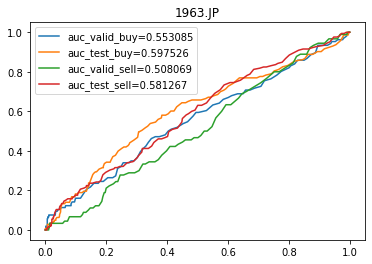

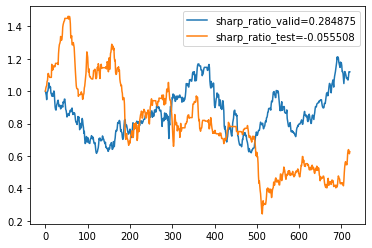

メタラベルあり


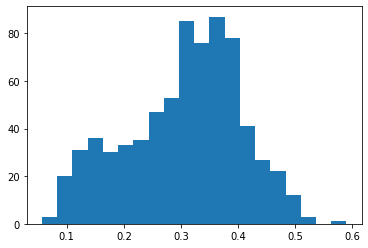

done 1963.JP


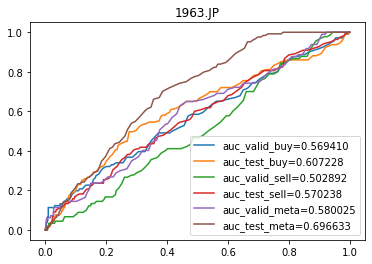

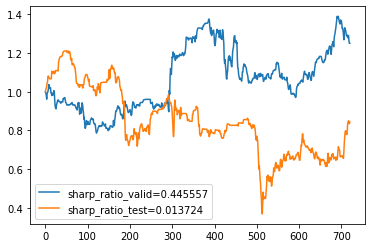

CPU times: user 1min 17s, sys: 90.2 ms, total: 1min 18s
Wall time: 1min 18s


In [ ]:
%%time
# 銘柄1つの結果の出力
import warnings
warnings.filterwarnings('ignore')

print('メタラベルなし')
res = make_model(df_master, symbols_modified[10], symbols_modified, metalabel=False, plot=True)

print('メタラベルあり')
res = make_model(df_master, symbols_modified[10], symbols_modified, metalabel=True, plot=True)

In [ ]:
%%time
# 全銘柄の結果の出力
import warnings
warnings.filterwarnings('ignore')

from multiprocessing import Pool

def make_model_wraper(i):
  return make_model(df_master, symbols_modified[i], symbols_modified)

with Pool(4) as p:
  results = p.map(make_model_wraper, range(len(symbols_modified)))

Output hidden; open in https://colab.research.google.com to view.

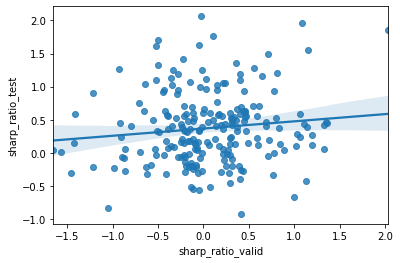

In [ ]:
# validとtestのシャープレシオ比較
sharp_ratio_test = [result['sharp_ratio_test'] for result in results]
sharp_ratio_valid = [result['sharp_ratio_valid'] for result in results]
sns.regplot(sharp_ratio_valid, sharp_ratio_test)
plt.ylabel('sharp_ratio_test')
plt.xlabel('sharp_ratio_valid')
plt.show()

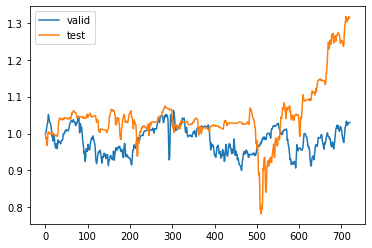

In [ ]:
#全データの平均値
returns_cum_valid = [result['returns_cum_valid'] for result in results]
returns_cum_test = [result['returns_cum_test'] for result in results]

returns_cum_valid_mean = np.mean(returns_cum_valid, axis=0)
returns_cum_test_mean = np.mean(returns_cum_test, axis=0)

plt.plot(returns_cum_valid_mean, label='valid')
plt.plot(returns_cum_test_mean, label='test')
plt.legend()
plt.show()

top5


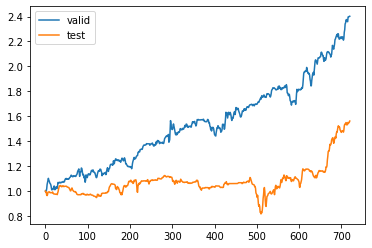

top10


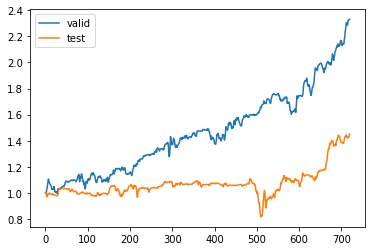

top20


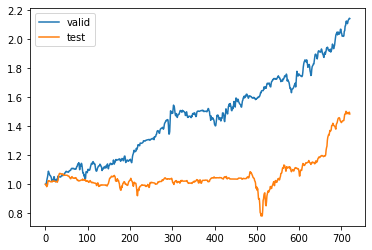

In [ ]:
# validation期間でシャープレシオがトップだった銘柄のパフォーマンス
print('top5')
plt_top_n(top_n = 5)

print('top10')
plt_top_n(top_n = 10)

print('top20')
plt_top_n(top_n = 20)